In [9]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [10]:
df_wemby = pd.read_csv('wemby_2024_individual.csv')
df_dpoy = pd.read_csv('dpoy_winners.csv')

In [11]:
df = pd.concat([df_wemby, df_dpoy], axis=0)

In [12]:
#If players name is not Victor Wembanyama, then they are DPOY
df['Is_DPOY'] = df['Name'] != 'Victor Wembanyama'
df

,MIN,REB,STL,BLK,BLK/48,REB/48,STL/48,Name,Date,Is_DPOY
0,23.0,5,2,1,2.086957,10.434783,4.173913,Victor Wembanyama,2023-24,False
1,31.0,12,3,3,4.645161,18.580645,4.645161,Victor Wembanyama,2023-24,False
2,26.0,5,1,1,1.846154,9.230769,1.846154,Victor Wembanyama,2023-24,False
3,28.0,8,0,4,6.857143,13.714286,0.000000,Victor Wembanyama,2023-24,False
4,34.0,10,1,2,2.823529,14.117647,1.411765,Victor Wembanyama,2023-24,False
...,...,...,...,...,...,...,...,...,...,...
2556,35.0,16,1,5,6.857143,21.942857,1.371429,Ben Wallace,2004-05,True
2557,42.0,11,2,1,1.142857,12.571429,2.285714,Ben Wallace,2005-06,True
2558,42.0,11,2,1,1.142857,12.571429,2.285714,Ben Wallace,2004-05,True
2559,38.0,10,3,3,3.789474,12.631579,3.789474,Ben Wallace,2005-06,True


In [19]:
#Perform Kolmogorov-smirnov test to see whether the data is normally distributed
from scipy.stats import kstest

ks_results = {}
for stat in ["BLK/48", "REB/48", "STL/48"]:
    ks_stat, ks_p_value = kstest(df_wemby[stat], 'norm', args=(df_wemby[stat].mean(), df_wemby[stat].std()))
    ks_results[stat] = (ks_stat, ks_p_value)

ks_results

{'BLK/48': (0.10236898198119287, 0.5542059127260285),
 'REB/48': (0.05868715497438337, 0.9829656925600124),
 'STL/48': (0.16211811325976133, 0.08912166794890641)}

From Kolmogorov-Smirnov test, we see that all of Wembanyama's defensive stats follow normal distribution. So, we can use Z-score to compare his stats with other players.

Let's do a simple t-test to check whether there are significant difference between defensive metrics among DPOY winners

In [13]:
from scipy.stats import ttest_ind
metrics = ["BLK/48", "REB/48", "STL/48"]
t_test_results = {}

for metric in metrics:
    wemby_stats = df[df['Name'] == 'Victor Wembanyama'][metric]
    dpoy_stats = df[df['Is_DPOY']][metric]
    
    t_stat, p_val = ttest_ind(wemby_stats, dpoy_stats, equal_var=False)
    t_test_results[metric] = {'t_stat': t_stat, 'p_val': p_val}
for metric, results in t_test_results.items():
    print(f"{metric} - t-statistic: {results['t_stat']}, p-value: {results['p_val']}")

BLK/48 - t-statistic: 5.813854028632058, p-value: 2.8581623861035486e-07
REB/48 - t-statistic: 1.412922362919354, p-value: 0.16293599742134537
STL/48 - t-statistic: 1.378830840586916, p-value: 0.17327703560721278


What do they mean?
1. BLK/48 t-stat = 5.81, p-value=2.85e-07
Since p-value is significantly less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in BLK/48 between DPOY winners and Victor Wembanyama, and since the t-stat is positive, we can conclude that DPOY winners have lower BLK/48 than Victor Wembanyama.
2. REB/48 t-stat = 1.41, p-value = 0.16
Since p-value is significantly greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant difference in REB/48 between DPOY winners and Victor Wembanyama.
3. STL/48 t-stat = 1.38, p-value = 0.17
Since p-value is significantly greater than 0.05, we fail to reject the null hypothesis and conclude that there is no significant difference in STL/48 between DPOY winners and Victor Wembanyama.

In summary:
Wembanyama's block rate is significantly different and higher than that of DPOY winners of previous seasons.
There is no statistically significant difference in the rebound and steal rates per 48 minutes when comparing Wembanyama to DPOY winners, based on the data you have.


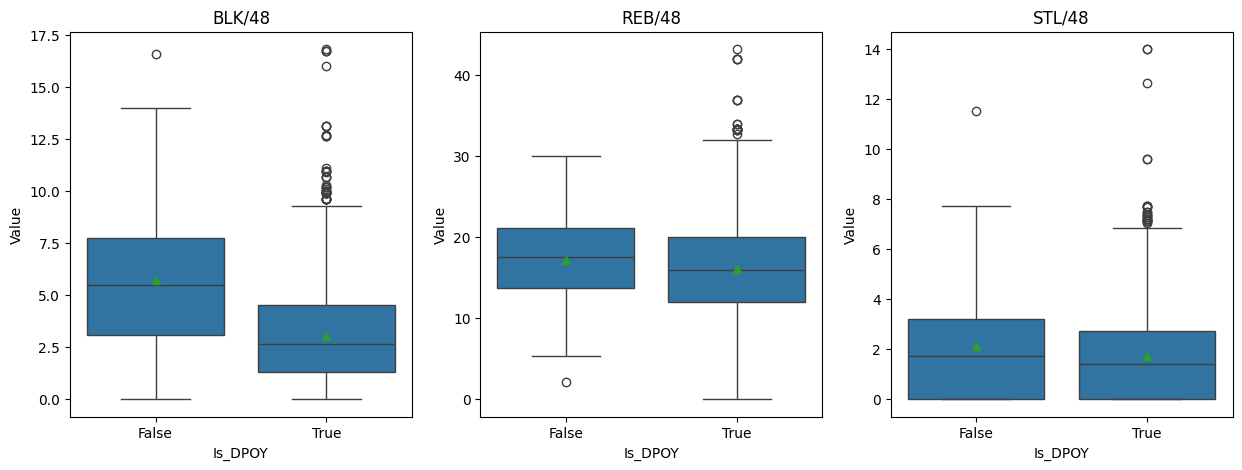

In [17]:
#The plots show that Victor Wembanyama is better than the average DPOY in all three metrics
melted_df = df.melt(id_vars=['Name', 'Is_DPOY'], value_vars=["BLK/48", "REB/48", "STL/48"], var_name='Metric', value_name='Value')
#Boxplots
plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.title(metric)
    sns.boxplot(x='Is_DPOY', y='Value', data=melted_df[melted_df['Metric'] == metric], showmeans=True, legend='full')

Comparing to Average DPOY winner, Victor Wembanyama is better at blocking shots, but not as good at rebounding and stealing the ball. All of this, while he's still a rookie is beyond impressive!